In [1]:
import pandas as pd
from tshistory.api import timeseries
import requests, warnings
import matplotlib.pyplot as plt
from BlueOcean import DataAccessApi

tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')
server = 'https://TST-QDEV-AP1.petroineos.local:5001'
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
plt.style.use('ggplot')

In [3]:
def bo_get_data(query):
    data = DataAccessApi.GetDataframe(query)
    return data

In [7]:
kpler_commercial = tsa.get('crude.kpler.oecd.commercial_stocks.mb.daily').resample('MS').mean()
oecd_commercial_kt = tsa.get('crude.iea.oecd_total.commercial_stocks.kt.monthly')
oecd_commercial_kb = oecd_commercial_kt*7.33/1000

In [12]:
kpler_commercial_mav = tsa.get('crude.kpler.oecd.commercial_stocks.mb.daily').rolling(14).mean()

<Axes: >

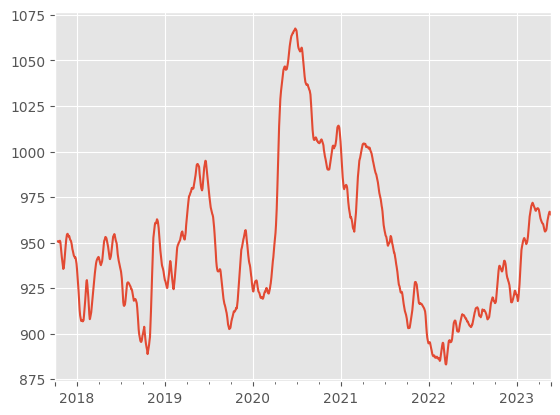

In [13]:
# ax1 = kpler_commercial.plot()
# ax2 = ax1.twinx()
# oecd_commercial_kb.plot(ax=ax2, color='navy')

kpler_commercial_mav.plot()

#### Aim: Extracting, comparing and uploading IEA flows to saturn for OECD EU balance
TIP: run in flows / base env

### Flow comparison

In [2]:
def ag_get_data(query):
    warnings.simplefilter('ignore', requests.packages.urllib3.exceptions.InsecureRequestWarning)
    params = {"Database": "OIL", "Query": query}
    resp = requests.post('https://TST-QDEV-AP1.petroineos.local:5001/genericdata/Fetch/', json=params, verify=False)
    json_result = resp.json()
    df = pd.DataFrame(json_result)
    return df

In [3]:
def clean(df):
    df['month'] = pd.to_datetime(df['month'])
    df['kbbls'] = df['value']*7.33
    df['kbd'] = df['kbbls']/df['month'].dt.daysinmonth
    df.set_index('month', inplace=True)
    df.sort_index(inplace=True)
    return df

In [8]:
qry = "select * from OIL.dbo.IeaOilImpor where DestCountry = 'OECDEUR'"

In [11]:
oecd_imports_eu = '''select month, sum(value) value from oil.dbo.IeaOilImpor
where ProductType='CRUDEOIL' and DestCountry='OECDEUR' and PDate=(select max(pdate) from oil.dbo.IeaOilImpor)
and SourceCountry in ('AUSTRIA','BELGIUM','CZECH','DENMARK','ESTONIA','FINLAND','FRANCE','GERMANY','GREECE','HUNGARY','ICELAND','IRELAND','ITALY','LATVIA','LITHUANI','LITHUANIA','LUXEMBOU','NETHLAND','NORWAY','POLAND','PORTUGAL','SLOVAKIA','SLOVENIA','SPAIN','SWEDEN','SWITLAND','TURKEY','UK')
group by month'''

In [12]:
russia_qry = """select month, value from oil.dbo.IeaOilImpor 
where ProductType='CRUDEOIL' and DestCountry='OECDEUR' and SourceCountry='Russia' and PDate=(select max(pdate) from oil.dbo.IeaOilImpor)"""

In [13]:
def get_data(c):
    query = f"""select month, value from oil.dbo.IeaOilImpor where ProductType='CRUDEOIL' and DestCountry='OECDEUR' 
    and SourceCountry='{c}' and PDate=(select max(pdate) from oil.dbo.IeaOilImpor)"""
    df = clean(ag_get_data(query))
    return df

In [16]:
oecd_imports_qry = '''select month, sum(value) value from oil.dbo.IeaOilImpor
where ProductType='CRUDEOIL' and DestCountry='OECDEUR' and PDate=(select max(pdate) from oil.dbo.IeaOilImpor)
and SourceCountry not in ('AUSTRIA','BELGIUM','CZECH','DENMARK','ESTONIA','FINLAND','FRANCE','GERMANY','GREECE','HUNGARY','ICELAND','IRELAND','ITALY','LATVIA','LITHUANI','LITHUANIA','LUXEMBOU','NETHLAND','NORWAY','POLAND','PORTUGAL','SLOVAKIA','SLOVENIA','SPAIN','SWEDEN','SWITLAND','TURKEY','UK','FSU','TOTIMPST', 'TOTOPEC','TOTOECD')
group by month'''

iea_imports_total = get_data('TOTIMPST')
oecd_imports = clean(ag_get_data(oecd_imports_qry))
oecd_imports.kbd.plot()

### OECD EU Exports

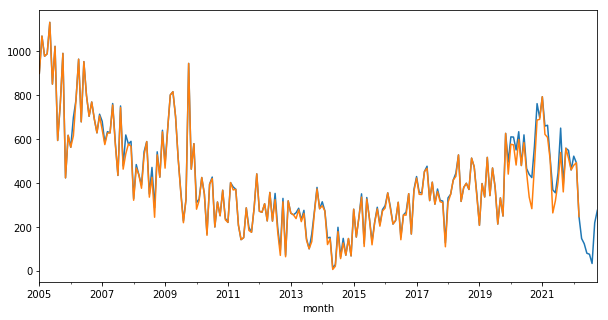

In [8]:
oecd_exports_qry = '''select month, sum(value) value from oil.dbo.IeaOilExpor
where ProductType='CRUDEOIL' and SourceCountry='OECDEUR' and PDate=(select max(pdate) from oil.dbo.IeaOilExpor)
and DestCountry not in ('AUSTRIA','BELGIUM','CZECH','DENMARK','ESTONIA','FINLAND','FRANCE','GERMANY','GREECE','HUNGARY','ICELAND','IRELAND','ITALY','LATVIA','LITHUANI','LITHUANIA','LUXEMBOU','NETHLAND','NORWAY','POLAND','PORTUGAL','SLOVAKIA','SLOVENIA','SPAIN','SWEDEN','SWITLAND','TURKEY','UK','TOTEXPST', 'TOTOECD')
group by month'''

exp_tsa = tsa.get("crude.iea.oecd_europe.exports.kbd.monthly")
oecd_exports = clean(ag_get_data(oecd_exports_qry))
fig, ax = plt.subplots(1,figsize=(10,5))
oecd_exports.kbd.plot(ax=ax)
exp_tsa.plot(ax=ax)

### upload data to saturn

In [10]:
# name = 'crude.iea.oecd_europe.imports.kbd.monthly'
# tsa.update(name, oecd_imports['kbd'], 'Syed Ahmad')
# exp_name = 'crude.iea.oecd_europe.exports.kbd.monthly'
# tsa.update(exp_name, oecd_exports['kbd'], 'Syed Ahmad')

### comparison of IEA tradeflows 'TOTIMPST' vs aggregation of IEA OECDEUR imports

In [99]:
comparison = pd.merge(iea_imports_total['kbd'],oecd_imports['kbd'], left_index=True, right_index=True)

In [100]:
comparison.plot(y=['kbd_x', 'kbd_y'])

In [103]:
comparison['diff'] = comparison['kbd_x'] - comparison['kbd_y']

In [104]:
comparison['diff'].plot()

Differnce between two aggregations looks like the OECD europe production profile

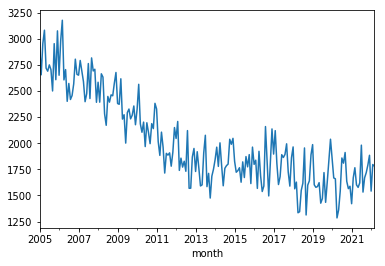

In [110]:
# taking OECD europe intra flows
oecd_intra = clean(ag_get_data(oecd_imports_eu))['kbd']
oecd_intra.plot()

In [108]:
comparison['diff_minus_intra'] = comparison['diff'] - oecd_intra

In [109]:
comparison['diff_minus_intra'].plot()

difference is all but eliminated when correcting for intra flows

In [38]:
saudi = get_data('SAUDIARABI')

In [39]:
saudi.kbd.plot()